#### Import Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# from tool import model as md
from utils.tools import getblast
from sklearn.metrics import classification_report
import os
import sys 
sys.path.append("../../")
import scipy.sparse as sp
from scripts.data_loader import data_loader
seed = 42 
np.random.seed(seed)

In [3]:
train_node = pd.read_csv("../../data/Process/train_node.csv")
test_node = pd.read_csv("../../data/Process/test_node.csv")

In [4]:
train_fasta_df = train_node[["id","amino_acid_seq:String","~label"]]
test_fasta_df = test_node[["id","amino_acid_seq:String","~label"]]
train_data = train_fasta_df.rename(columns={'Entry':'id','amino_acid_seq:String':'seq',"~label":"label"})
vali_data = test_fasta_df.rename(columns={'Entry':'id','amino_acid_seq:String':'seq',"~label":"label"})

In [5]:
diamond_task = getblast(train = train_data, test = vali_data)
diamond_task

Write finished
Write finished
diamond makedb --in /tmp/train.fasta -d /tmp/train.dmnd --quiet
diamond blastp -d /tmp/train.dmnd  -q  /tmp/test.fasta -o /tmp/test_fasta_results.tsv -b5 -c1 -k 1 -e 1e-5 --quiet


,id,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
0,b4015,b0331,26.8,265,132,9,61,322,15,220,4.100000e-16,79.3
1,b2405,b0338,30.8,227,156,1,12,238,6,231,1.300000e-21,97.1
2,b3651,b4180,30.2,159,104,3,11,165,87,242,3.600000e-11,62.0
3,b2287,b2719,36.9,157,86,5,60,205,47,201,1.300000e-21,96.7
4,b0860,b0863,64.7,241,85,0,1,241,1,241,2.300000e-93,335.1
...,...,...,...,...,...,...,...,...,...,...,...,...
260,b4053,b1190,42.2,346,197,2,8,353,9,351,8.500000e-76,277.3
261,b3671,b4488,46.9,548,283,4,15,560,3,544,4.400000e-143,501.5
262,b1395,b2341,36.4,280,174,4,5,283,308,584,1.300000e-39,157.5
263,b3240,b1645,22.8,521,361,12,12,513,22,520,9.000000e-15,75.5


#### Evaluate

In [6]:
# 按照Query列分组，取每个组中最相似的记录
best_matches_df = diamond_task.loc[diamond_task.groupby('id')['bitscore'].idxmax()]
best_matches_df

,id,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore
166,b0014,b0650,30.0,590,348,13,5,585,8,541,1.800000e-68,253.8
225,b0015,b1000,30.4,349,185,7,1,347,1,293,8.500000e-34,137.9
148,b0026,b4258,21.5,819,468,19,46,775,30,762,6.800000e-40,159.5
9,b0032,b1263,27.8,144,93,5,219,356,35,173,3.100000e-07,49.7
49,b0036,b1393,36.4,264,156,7,1,261,1,255,1.700000e-33,136.3
...,...,...,...,...,...,...,...,...,...,...,...,...
168,b4356,b3127,31.2,420,264,7,44,443,20,434,8.900000e-54,204.5
138,b4460,b3568,33.2,331,159,2,50,318,56,386,5.000000e-30,125.2
16,b4464,b4064,82.0,450,80,1,6,455,1,449,2.300000e-195,674.9
197,b4477,b1850,25.5,161,115,3,8,166,16,173,7.700000e-13,67.4


In [7]:
label_merge = pd.merge(best_matches_df,train_data[['id','label']], left_on="sseqid", right_on="id")
label_merge = pd.merge(label_merge,vali_data[['id','label']], left_on="id_x", right_on="id")
result = label_merge[['id_x', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen',
       'qstart', 'qend', 'sstart', 'send', 'evalue',
       'bitscore','label_x', 'label_y']]
result.columns = ['Query', 'Subject', 'Identity', 'Length', 'Mismatches', 'Gaps',
       'Query_start', 'Query_end', 'Subject_start', 'Subject_end', 'E_value',
       'Bit_score','Predict', 'GroundTruth']
predict_miss = vali_data[vali_data.id.isin((set(vali_data.id)-set(result.Query)))][["id","label"]]
result

,Query,Subject,Identity,Length,Mismatches,Gaps,Query_start,Query_end,Subject_start,Subject_end,E_value,Bit_score,Predict,GroundTruth
0,b0014,b0650,30.0,590,348,13,5,585,8,541,1.800000e-68,253.8,0,0
1,b0015,b1000,30.4,349,185,7,1,347,1,293,8.500000e-34,137.9,0,0
2,b0026,b4258,21.5,819,468,19,46,775,30,762,6.800000e-40,159.5,0,0
3,b0032,b1263,27.8,144,93,5,219,356,35,173,3.100000e-07,49.7,0,0
4,b0036,b1393,36.4,264,156,7,1,261,1,255,1.700000e-33,136.3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,b4356,b3127,31.2,420,264,7,44,443,20,434,8.900000e-54,204.5,0,0
261,b4460,b3568,33.2,331,159,2,50,318,56,386,5.000000e-30,125.2,0,0
262,b4464,b4064,82.0,450,80,1,6,455,1,449,2.300000e-195,674.9,0,0
263,b4477,b1850,25.5,161,115,3,8,166,16,173,7.700000e-13,67.4,0,0


In [8]:
groundtruth = np.concatenate([result["GroundTruth"].values,predict_miss.label.values])
predict = np.concatenate([result["Predict"].values,np.zeros(len(predict_miss))])

In [9]:
blast_report = pd.DataFrame(classification_report(groundtruth, predict, zero_division=0, output_dict=True)).T
blast_report

,precision,recall,f1-score,support
0,0.954853,0.997642,0.975779,848.000000
1,0.916667,0.354839,0.511628,62.000000
accuracy,0.953846,0.953846,0.953846,0.953846
macro avg,0.935760,0.676240,0.743703,910.000000
weighted avg,0.952252,0.953846,0.944155,910.000000


In [12]:
np.savez("../../output/baseline/Blastp.npz", label=groundtruth, prob=predict)

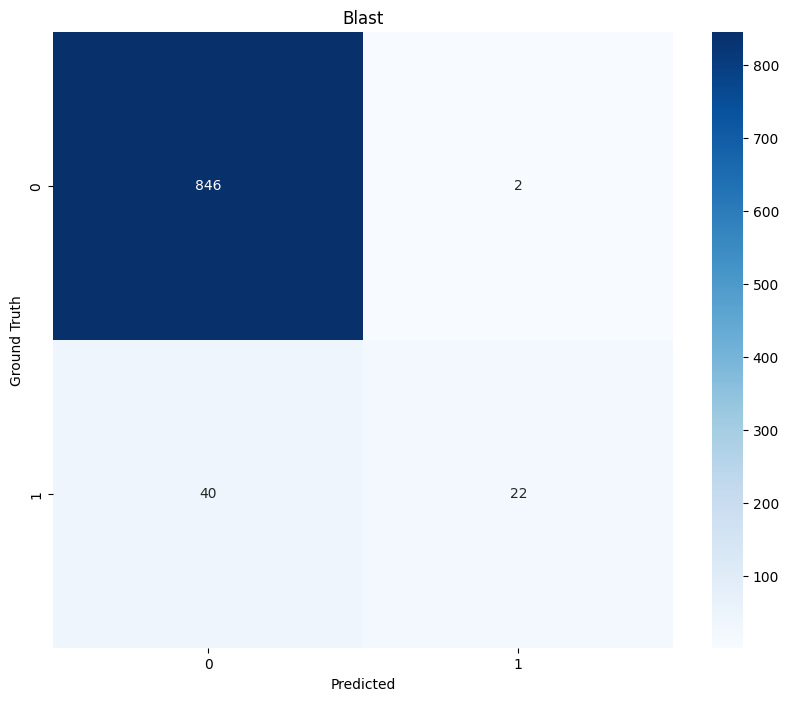

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 假设你有groundtruth和predict的数据
groundtruth = np.array(groundtruth)
predict = np.array(predict)

# 计算混淆矩阵
cm = confusion_matrix(groundtruth, predict)

# 使用seaborn库绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')
plt.title('Blast')
plt.show()
